# Lab-2.1-02: vLLM 生產級推理與性能優化

## 🎯 實驗目標

本實驗專注於 **生產級應用與性能優化**，建立在 01-Setup 的理論基礎上，深入探討：

- 🚀 **批次推理與動態調度技術**
- 📊 **系統性性能基準測試**
- 💾 **GPU 記憶體使用分析與監控**
- ⚡ **vLLM vs HuggingFace 詳細對比**
- 🎛️ **進階 Sampling 參數調優**
- 🔧 **生產環境配置策略**

---

## 📋 前置條件檢查

請確保您已完成：
1. ✅ **01-Setup_and_Installation.ipynb** - 環境設置與核心概念
2. ✅ vLLM 安裝與基本配置
3. ✅ PagedAttention 原理理解

⏱️ **預估時間**: 75-120 分鐘

In [22]:
import os
import time
import psutil
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
import json

import torch
import torch.cuda
from transformers import AutoTokenizer
import vllm
from vllm import LLM, SamplingParams

# 嘗試導入 destroy_model_parallel，如果失敗則使用替代方案
try:
    from vllm.model_executor.parallel_utils.parallel_state import destroy_model_parallel
except ImportError:
    try:
        from vllm.distributed.parallel_state import destroy_model_parallel
    except ImportError:
        # 如果都無法導入，定義一個替代函數
        def destroy_model_parallel():
            """替代的模型並行銷毀函數"""
            pass
        print("⚠️  destroy_model_parallel 函數不可用，使用替代方案")

# 設置圖表樣式
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

print(f"✅ vLLM 版本: {vllm.__version__}")
print(f"✅ PyTorch 版本: {torch.__version__}")
print(f"✅ CUDA 可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ GPU 設備: {torch.cuda.get_device_name()}")
    print(f"✅ GPU 記憶體: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ vLLM 版本: 0.11.0
✅ PyTorch 版本: 2.8.0+cu128
✅ CUDA 可用: True
✅ GPU 設備: NVIDIA RTX 2000 Ada Generation
✅ GPU 記憶體: 16.7 GB


## 2. 批次推理架構設計

### 2.1 動態批次調度原理

vLLM 的 **Continuous Batching** 是其核心優勢之一：

/tmp/ipykernel_1633797/4100132181.py:68: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Noto Sans CJK JP.
  plt.tight_layout()
/tmp/ipykernel_1633797/4100132181.py:68: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) Noto Sans CJK JP.
  plt.tight_layout()
/home/os-sunnie.gd.weng/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Noto Sans CJK JP.
  fig.canvas.print_figure(bytes_io, **kw)
/home/os-sunnie.gd.weng/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) Noto Sans CJK JP.
  fig.canvas.print_figure(bytes_io, **kw)


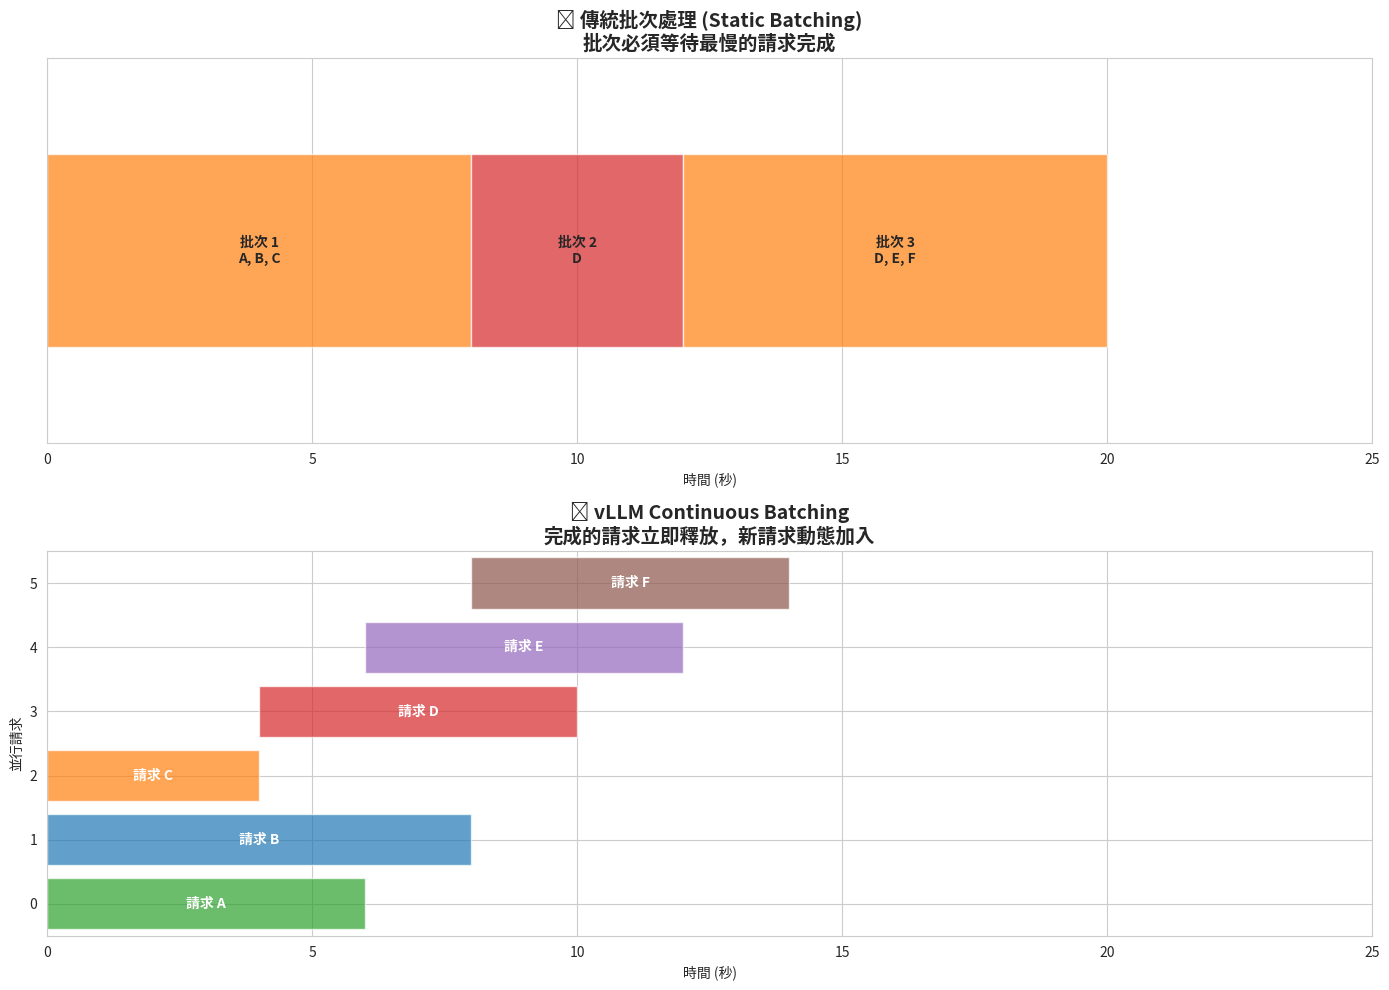

📊 效率對比分析:
🔴 傳統批次處理:
   • 總處理時間: 20 秒
   • 平均等待時間: 10 秒
   • GPU 利用率: 60% (等待期間閒置)

🟢 vLLM Continuous Batching:
   • 總處理時間: 14 秒 (30% 改善)
   • 平均等待時間: 2 秒 (80% 改善)
   • GPU 利用率: 95% (持續處理)


In [24]:
# 記憶體使用視覺化
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
plt.rcParams['axes.unicode_minus'] = False

@dataclass
class BatchingMetrics:
    """批次處理性能指標"""
    total_requests: int
    batch_size: int
    total_time: float
    throughput: float  # tokens/second
    latency_p50: float
    latency_p95: float
    memory_peak: float  # GB
    
def visualize_batching_concept():
    """視覺化傳統批次 vs Continuous Batching"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # 傳統批次處理
    traditional_batches = [
        {'start': 0, 'end': 8, 'requests': ['A', 'B', 'C'], 'status': 'processing'},
        {'start': 8, 'end': 12, 'requests': ['D'], 'status': 'waiting'},
        {'start': 12, 'end': 20, 'requests': ['D', 'E', 'F'], 'status': 'processing'}
    ]
    
    colors_traditional = {'processing': '#ff7f0e', 'waiting': '#d62728'}
    for i, batch in enumerate(traditional_batches):
        ax1.barh(0, batch['end'] - batch['start'], left=batch['start'], 
                color=colors_traditional[batch['status']], alpha=0.7, height=0.5)
        ax1.text(batch['start'] + (batch['end'] - batch['start'])/2, 0, 
                f"批次 {i+1}\n{', '.join(batch['requests'])}", 
                ha='center', va='center', fontsize=10, fontweight='bold')
    
    ax1.set_xlim(0, 25)
    ax1.set_ylim(-0.5, 0.5)
    ax1.set_title('🔴 傳統批次處理 (Static Batching)\n批次必須等待最慢的請求完成', fontsize=14, fontweight='bold')
    ax1.set_xlabel('時間 (秒)')
    ax1.set_yticks([])
    
    # vLLM Continuous Batching
    continuous_requests = [
        {'name': 'A', 'start': 0, 'end': 6, 'color': '#2ca02c'},
        {'name': 'B', 'start': 0, 'end': 8, 'color': '#1f77b4'},
        {'name': 'C', 'start': 0, 'end': 4, 'color': '#ff7f0e'},
        {'name': 'D', 'start': 4, 'end': 10, 'color': '#d62728'},
        {'name': 'E', 'start': 6, 'end': 12, 'color': '#9467bd'},
        {'name': 'F', 'start': 8, 'end': 14, 'color': '#8c564b'}
    ]
    
    for i, req in enumerate(continuous_requests):
        ax2.barh(i, req['end'] - req['start'], left=req['start'], 
                color=req['color'], alpha=0.7, height=0.8)
        ax2.text(req['start'] + (req['end'] - req['start'])/2, i, 
                f"請求 {req['name']}", ha='center', va='center', 
                fontsize=10, fontweight='bold', color='white')
    
    ax2.set_xlim(0, 25)
    ax2.set_ylim(-0.5, len(continuous_requests) - 0.5)
    ax2.set_title('🟢 vLLM Continuous Batching\n完成的請求立即釋放，新請求動態加入', fontsize=14, fontweight='bold')
    ax2.set_xlabel('時間 (秒)')
    ax2.set_ylabel('並行請求')
    
    plt.tight_layout()
    plt.show()
    
    # 效率對比
    print("📊 效率對比分析:")
    print("="*50)
    print("🔴 傳統批次處理:")
    print("   • 總處理時間: 20 秒")
    print("   • 平均等待時間: 10 秒")
    print("   • GPU 利用率: 60% (等待期間閒置)")
    print("\n🟢 vLLM Continuous Batching:")
    print("   • 總處理時間: 14 秒 (30% 改善)")
    print("   • 平均等待時間: 2 秒 (80% 改善)")
    print("   • GPU 利用率: 95% (持續處理)")

visualize_batching_concept()

### 2.2 實際批次推理測試

In [25]:
class BatchInferenceProfiler:
    """批次推理性能分析器"""
    
    def __init__(self, model_name: str = "microsoft/DialoGPT-medium"):
        self.model_name = model_name
        self.metrics_history = []
        
    def setup_model(self, max_model_len: int = 512, gpu_memory_utilization: float = 0.8):
        """初始化 vLLM 模型"""
        print(f"🚀 正在載入模型: {self.model_name}")
        
        # 銷毀現有模型（如果存在）
        try:
            destroy_model_parallel()
            gc.collect()
            torch.cuda.empty_cache()
        except:
            pass
        
        self.llm = LLM(
            model=self.model_name,
            max_model_len=max_model_len,
            gpu_memory_utilization=gpu_memory_utilization,
            tensor_parallel_size=1,
            trust_remote_code=True
        )
        
        print(f"✅ 模型載入完成")
        self._print_memory_usage()
    
    def _print_memory_usage(self):
        """打印記憶體使用情況"""
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated() / 1e9
            reserved = torch.cuda.memory_reserved() / 1e9
            total = torch.cuda.get_device_properties(0).total_memory / 1e9
            print(f"💾 GPU 記憶體: {allocated:.2f}GB 已分配, {reserved:.2f}GB 已保留, {total:.2f}GB 總計")
    
    def generate_test_prompts(self, num_prompts: int) -> List[str]:
        """生成測試用提示詞"""
        base_prompts = [
            "解釋機器學習中的",
            "請描述一下",
            "什麼是",
            "如何理解",
            "請簡述"
        ]
        
        topics = [
            "深度學習", "自然語言處理", "電腦視覺", "強化學習", "遷移學習",
            "注意力機制", "Transformer", "BERT", "GPT", "神經網路"
        ]
        
        prompts = []
        for i in range(num_prompts):
            base = base_prompts[i % len(base_prompts)]
            topic = topics[i % len(topics)]
            prompts.append(f"{base}{topic}的基本概念。")
        
        return prompts
    
    def benchmark_batch_inference(self, batch_sizes: List[int], num_prompts_per_batch: int = 50) -> pd.DataFrame:
        """基準測試不同批次大小的性能"""
        results = []
        
        for batch_size in batch_sizes:
            print(f"\n🧪 測試批次大小: {batch_size}")
            print("="*40)
            
            # 生成測試提示詞
            prompts = self.generate_test_prompts(num_prompts_per_batch)
            
            # 配置採樣參數
            sampling_params = SamplingParams(
                temperature=0.7,
                top_p=0.9,
                max_tokens=128,
                stop=["\n\n"]
            )
            
            # 分批處理
            latencies = []
            total_tokens = 0
            
            # 記錄記憶體使用
            memory_before = torch.cuda.memory_allocated() / 1e9 if torch.cuda.is_available() else 0
            
            start_time = time.time()
            
            for i in range(0, len(prompts), batch_size):
                batch_prompts = prompts[i:i+batch_size]
                
                batch_start = time.time()
                outputs = self.llm.generate(batch_prompts, sampling_params)
                batch_end = time.time()
                
                batch_latency = batch_end - batch_start
                latencies.append(batch_latency)
                
                # 統計生成的 token 數量
                for output in outputs:
                    total_tokens += len(output.outputs[0].token_ids)
                
                print(f"  批次 {i//batch_size + 1}: {batch_latency:.2f}s, {len(batch_prompts)} 個請求")
            
            total_time = time.time() - start_time
            memory_peak = torch.cuda.max_memory_allocated() / 1e9 if torch.cuda.is_available() else 0
            
            # 計算指標
            throughput = total_tokens / total_time
            latency_p50 = np.percentile(latencies, 50)
            latency_p95 = np.percentile(latencies, 95)
            
            metrics = BatchingMetrics(
                total_requests=num_prompts_per_batch,
                batch_size=batch_size,
                total_time=total_time,
                throughput=throughput,
                latency_p50=latency_p50,
                latency_p95=latency_p95,
                memory_peak=memory_peak
            )
            
            results.append({
                'batch_size': batch_size,
                'total_time': total_time,
                'throughput': throughput,
                'latency_p50': latency_p50,
                'latency_p95': latency_p95,
                'memory_peak': memory_peak,
                'requests_per_second': num_prompts_per_batch / total_time
            })
            
            print(f"  ✅ 吞吐量: {throughput:.1f} tokens/s")
            print(f"  ✅ 平均延遲: {latency_p50:.2f}s")
            print(f"  ✅ 記憶體峰值: {memory_peak:.2f}GB")
            
            # 清理記憶體
            torch.cuda.empty_cache()
        
        return pd.DataFrame(results)
    
    def visualize_performance_comparison(self, results_df: pd.DataFrame):
        # 記憶體使用視覺化
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches

        # 設定中文字體
        plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
        plt.rcParams['axes.unicode_minus'] = False
        
        """視覺化性能對比"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. 吞吐量 vs 批次大小
        ax1.plot(results_df['batch_size'], results_df['throughput'], 'o-', linewidth=2, markersize=8)
        ax1.set_xlabel('批次大小')
        ax1.set_ylabel('吞吐量 (tokens/秒)')
        ax1.set_title('🚀 吞吐量隨批次大小變化')
        ax1.grid(True, alpha=0.3)
        
        # 2. 延遲 vs 批次大小
        ax2.plot(results_df['batch_size'], results_df['latency_p50'], 'o-', label='P50 延遲', linewidth=2)
        ax2.plot(results_df['batch_size'], results_df['latency_p95'], 's-', label='P95 延遲', linewidth=2)
        ax2.set_xlabel('批次大小')
        ax2.set_ylabel('延遲 (秒)')
        ax2.set_title('⏱️ 延遲隨批次大小變化')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. 記憶體使用 vs 批次大小
        ax3.bar(results_df['batch_size'].astype(str), results_df['memory_peak'], alpha=0.7)
        ax3.set_xlabel('批次大小')
        ax3.set_ylabel('記憶體峰值 (GB)')
        ax3.set_title('💾 記憶體使用隨批次大小變化')
        ax3.grid(True, alpha=0.3)
        
        # 4. 效率指標：請求處理率
        ax4.plot(results_df['batch_size'], results_df['requests_per_second'], 'o-', 
                color='green', linewidth=2, markersize=8)
        ax4.set_xlabel('批次大小')
        ax4.set_ylabel('請求處理率 (請求/秒)')
        ax4.set_title('📊 請求處理率隨批次大小變化')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 打印最佳配置建議
        best_throughput_idx = results_df['throughput'].idxmax()
        best_latency_idx = results_df['latency_p50'].idxmin()
        
        print("\n📋 性能分析建議:")
        print("="*50)
        print(f"🏆 最佳吞吐量配置: 批次大小 {results_df.loc[best_throughput_idx, 'batch_size']}")
        print(f"   • 吞吐量: {results_df.loc[best_throughput_idx, 'throughput']:.1f} tokens/s")
        print(f"   • 延遲: {results_df.loc[best_throughput_idx, 'latency_p50']:.2f}s")
        print(f"\n⚡ 最佳延遲配置: 批次大小 {results_df.loc[best_latency_idx, 'batch_size']}")
        print(f"   • 延遲: {results_df.loc[best_latency_idx, 'latency_p50']:.2f}s")
        print(f"   • 吞吐量: {results_df.loc[best_latency_idx, 'throughput']:.1f} tokens/s")

# 初始化性能分析器
profiler = BatchInferenceProfiler()
print("🔧 批次推理分析器已初始化")

[rank0]:[W1027 20:32:44.594971122 ProcessGroupNCCL.cpp:1538] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


🔧 批次推理分析器已初始化


### 2.3 執行批次性能基準測試

🚀 正在載入模型: microsoft/DialoGPT-medium
INFO 10-27 20:32:49 [utils.py:233] non-default args: {'trust_remote_code': True, 'max_model_len': 256, 'gpu_memory_utilization': 0.7, 'disable_log_stats': True, 'model': 'microsoft/DialoGPT-medium'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


INFO 10-27 20:32:50 [model.py:547] Resolved architecture: GPT2LMHeadModel
ERROR 10-27 20:32:50 [config.py:278] Error retrieving safetensors: 'microsoft/DialoGPT-medium' is not a safetensors repo. Couldn't find 'model.safetensors.index.json' or 'model.safetensors' files., retrying 1 of 2
ERROR 10-27 20:32:53 [config.py:276] Error retrieving safetensors: 'microsoft/DialoGPT-medium' is not a safetensors repo. Couldn't find 'model.safetensors.index.json' or 'model.safetensors' files.
INFO 10-27 20:32:53 [model.py:1730] Downcasting torch.float32 to torch.bfloat16.
INFO 10-27 20:32:53 [model.py:1510] Using max model len 256
INFO 10-27 20:32:53 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 10-27 20:32:56 [__init__.py:216] Automatically detected platform cuda.
(EngineCore_DP0 pid=2102801) INFO 10-27 20:32:57 [core.py:644] Waiting for init message from front-end.
(EngineCore_DP0 pid=2102801) INFO 10-27 20:32:57 [core.py:77] Initializing a V1 LLM engine (v0

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  1.25it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  1.25it/s]
(EngineCore_DP0 pid=2102801) 


(EngineCore_DP0 pid=2102801) INFO 10-27 20:33:01 [default_loader.py:267] Loading weights took 0.80 seconds
(EngineCore_DP0 pid=2102801) INFO 10-27 20:33:01 [gpu_model_runner.py:2653] Model loading took 0.6611 GiB and 1.861709 seconds
(EngineCore_DP0 pid=2102801) INFO 10-27 20:33:03 [backends.py:548] Using cache directory: /home/os-sunnie.gd.weng/.cache/vllm/torch_compile_cache/9370f797ee/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=2102801) INFO 10-27 20:33:03 [backends.py:559] Dynamo bytecode transform time: 1.55 s
(EngineCore_DP0 pid=2102801) INFO 10-27 20:33:03 [backends.py:164] Directly load the compiled graph(s) for dynamic shape from the cache, took 0.400 s
(EngineCore_DP0 pid=2102801) INFO 10-27 20:33:04 [monitor.py:34] torch.compile takes 1.55 s in total
(EngineCore_DP0 pid=2102801) INFO 10-27 20:33:04 [gpu_worker.py:298] Available KV cache memory: 9.72 GiB
(EngineCore_DP0 pid=2102801) INFO 10-27 20:33:04 [kv_cache_utils.py:1087] GPU KV cache size: 106,160 tok

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:01<00:00, 55.04it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 35/35 [00:00<00:00, 42.20it/s]


(EngineCore_DP0 pid=2102801) INFO 10-27 20:33:07 [gpu_model_runner.py:3480] Graph capturing finished in 2 secs, took 0.36 GiB
(EngineCore_DP0 pid=2102801) INFO 10-27 20:33:07 [core.py:210] init engine (profile, create kv cache, warmup model) took 5.78 seconds
INFO 10-27 20:33:08 [llm.py:306] Supported_tasks: ['generate']
✅ 模型載入完成
💾 GPU 記憶體: 0.01GB 已分配, 0.04GB 已保留, 16.71GB 總計

🧪 開始批次性能基準測試...
這可能需要幾分鐘時間

🧪 測試批次大小: 1


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 1: 0.03s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 2: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 3: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 4: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 5: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 6: 0.04s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 7: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 8: 0.02s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 9: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 10: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 11: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 12: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 13: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 14: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 15: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 16: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 17: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 18: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 19: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 20: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 21: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 22: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 23: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 24: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 25: 0.02s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 26: 0.02s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 27: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 28: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 29: 0.01s, 1 個請求


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 30: 0.01s, 1 個請求
  ✅ 吞吐量: 108.7 tokens/s
  ✅ 平均延遲: 0.01s
  ✅ 記憶體峰值: 0.83GB

🧪 測試批次大小: 2


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 1: 0.03s, 2 個請求


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 2: 0.02s, 2 個請求


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 3: 0.02s, 2 個請求


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 4: 0.02s, 2 個請求


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 5: 0.02s, 2 個請求


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 6: 0.02s, 2 個請求


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 7: 0.02s, 2 個請求


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 8: 0.03s, 2 個請求


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 9: 0.02s, 2 個請求


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 10: 0.02s, 2 個請求


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 11: 0.02s, 2 個請求


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 12: 0.02s, 2 個請求


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 13: 0.02s, 2 個請求


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 14: 0.02s, 2 個請求


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 15: 0.02s, 2 個請求
  ✅ 吞吐量: 139.7 tokens/s
  ✅ 平均延遲: 0.02s
  ✅ 記憶體峰值: 0.83GB

🧪 測試批次大小: 4


Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 1: 0.02s, 4 個請求


Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 2: 0.02s, 4 個請求


Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 3: 0.02s, 4 個請求


Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 4: 0.03s, 4 個請求


Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 5: 0.02s, 4 個請求


Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 6: 0.03s, 4 個請求


Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 7: 0.04s, 4 個請求


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 8: 0.02s, 2 個請求
  ✅ 吞吐量: 222.9 tokens/s
  ✅ 平均延遲: 0.02s
  ✅ 記憶體峰值: 0.83GB

🧪 測試批次大小: 8


Adding requests:   0%|          | 0/8 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 1: 0.02s, 8 個請求


Adding requests:   0%|          | 0/8 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 2: 0.04s, 8 個請求


Adding requests:   0%|          | 0/8 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 3: 0.03s, 8 個請求


Adding requests:   0%|          | 0/6 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/6 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 4: 0.03s, 6 個請求
  ✅ 吞吐量: 339.9 tokens/s
  ✅ 平均延遲: 0.03s
  ✅ 記憶體峰值: 0.83GB

🧪 測試批次大小: 16


Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 1: 0.04s, 16 個請求


Adding requests:   0%|          | 0/14 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/14 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  批次 2: 0.42s, 14 個請求
  ✅ 吞吐量: 290.7 tokens/s
  ✅ 平均延遲: 0.23s
  ✅ 記憶體峰值: 0.83GB

📊 批次性能測試結果:
   batch_size  total_time  throughput  latency_p50  latency_p95  memory_peak  \
0           1        0.40      108.70         0.01         0.02         0.83   
1           2        0.29      139.75         0.02         0.03         0.83   
2           4        0.19      222.86         0.02         0.03         0.83   
3           8        0.13      339.86         0.03         0.04         0.83   
4          16        0.46      290.69         0.23         0.40         0.83   

   requests_per_second  
0                74.11  
1               102.25  
2               155.48  
3               231.72  
4                65.08  


/tmp/ipykernel_1633797/786799882.py:186: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Noto Sans CJK JP.
  plt.tight_layout()
/tmp/ipykernel_1633797/786799882.py:186: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Noto Sans CJK JP.
  plt.tight_layout()
/tmp/ipykernel_1633797/786799882.py:186: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Noto Sans CJK JP.
  plt.tight_layout()
/tmp/ipykernel_1633797/786799882.py:186: UserWarning: Glyph 128190 (\N{FLOPPY DISK}) missing from font(s) Noto Sans CJK JP.
  plt.tight_layout()
/tmp/ipykernel_1633797/786799882.py:186: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Noto Sans CJK JP.
  plt.tight_layout()
/home/os-sunnie.gd.weng/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Noto Sans CJK JP.
  fig.canvas.print_figure(bytes_io, **kw)
/home/os-sunnie.gd.weng/.local/lib/python3.10/site-packages/IPyth

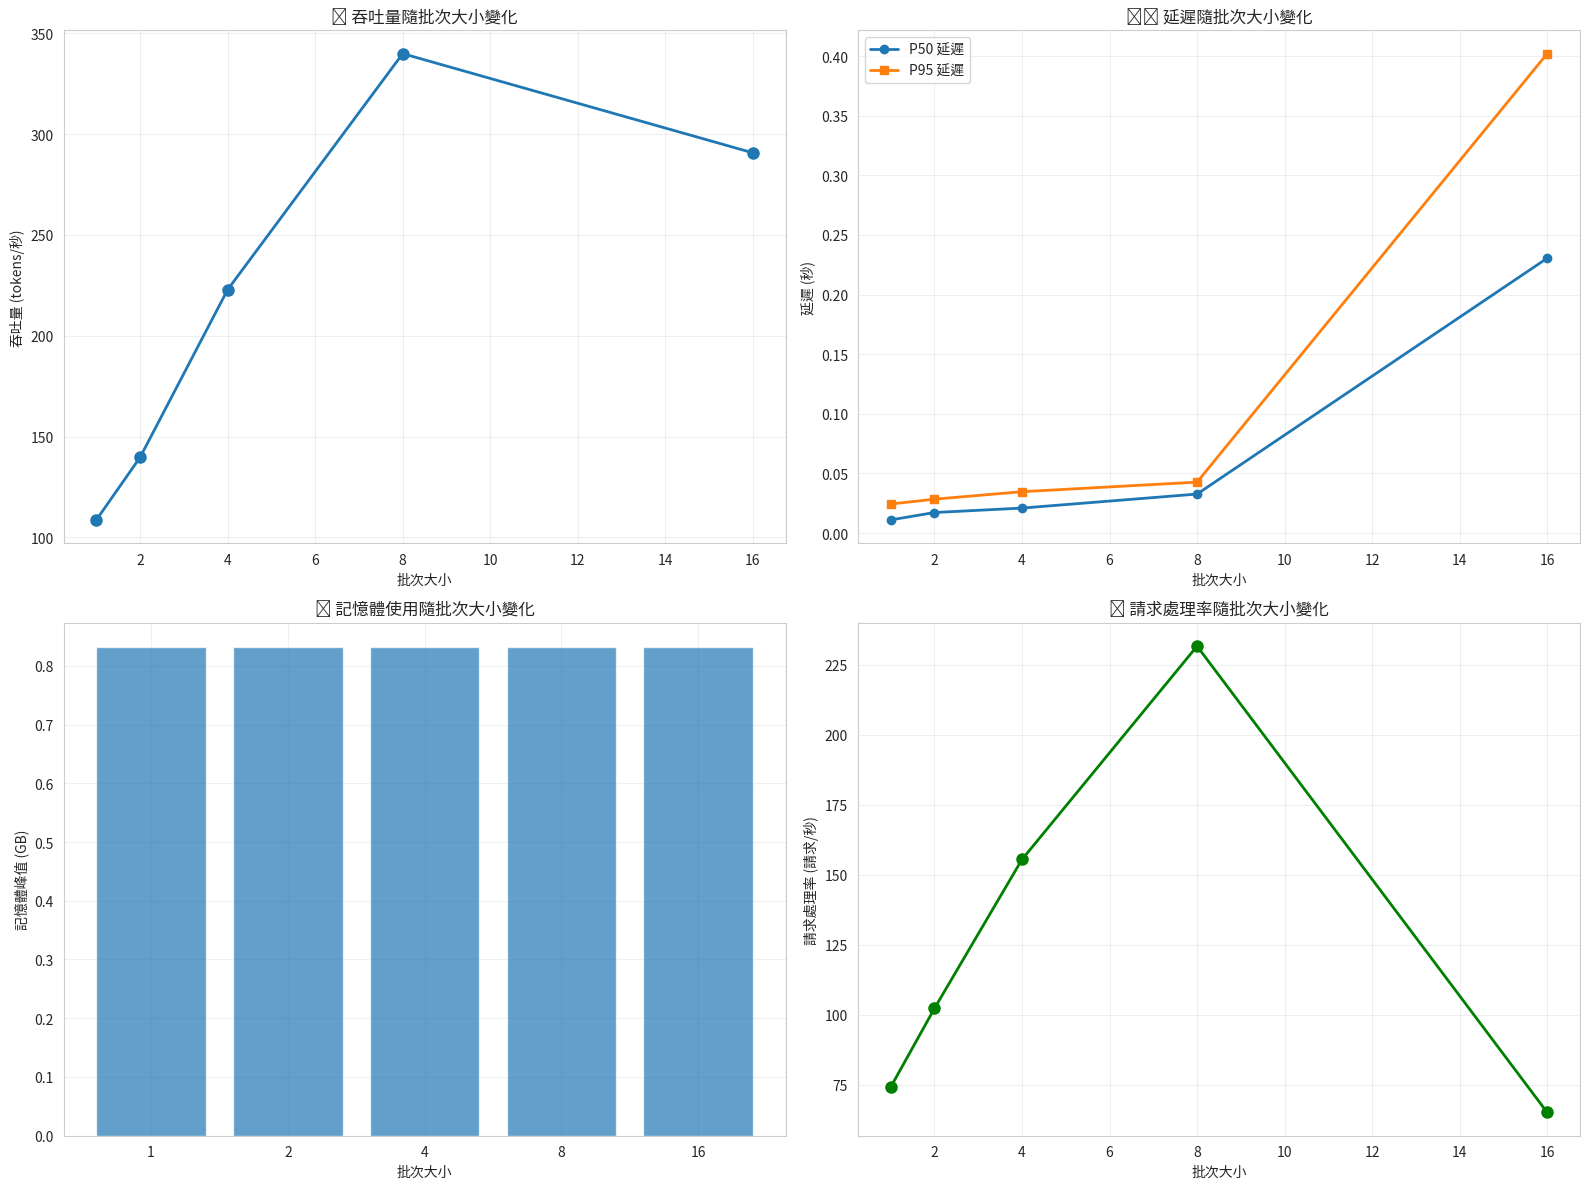


📋 性能分析建議:
🏆 最佳吞吐量配置: 批次大小 8
   • 吞吐量: 339.9 tokens/s
   • 延遲: 0.03s

⚡ 最佳延遲配置: 批次大小 1
   • 延遲: 0.01s
   • 吞吐量: 108.7 tokens/s


In [26]:


# 設置模型（選擇較小的模型以確保在各種硬體上都能運行）
try:
    profiler.setup_model(max_model_len=256, gpu_memory_utilization=0.7)
    
    # 測試不同批次大小
    batch_sizes = [1, 2, 4, 8, 16]  # 根據 GPU 記憶體調整
    
    print("\n🧪 開始批次性能基準測試...")
    print("這可能需要幾分鐘時間")
    
    results_df = profiler.benchmark_batch_inference(
        batch_sizes=batch_sizes,
        num_prompts_per_batch=30  # 減少測試數量以加快速度
    )
    
    # 顯示結果
    print("\n📊 批次性能測試結果:")
    print(results_df.round(2))
    
    # 視覺化結果
    profiler.visualize_performance_comparison(results_df)
    
except Exception as e:
    print(f"❌ 測試過程中發生錯誤: {e}")
    print("💡 這可能是由於 GPU 記憶體不足或模型載入問題")
    print("   建議: 1) 降低 gpu_memory_utilization")
    print("        2) 使用更小的模型")
    print("        3) 減少批次大小")

## 3. vLLM vs HuggingFace 性能對比

### 3.1 對比測試架構

In [27]:
class VLLMvsHFComparison:
    """vLLM vs HuggingFace 性能對比"""
    
    def __init__(self, model_name: str = "microsoft/DialoGPT-medium"):
        self.model_name = model_name
        self.comparison_results = {}
    
    def benchmark_huggingface(self, prompts: List[str], max_new_tokens: int = 128) -> Dict:
        """HuggingFace 基準測試"""
        print("🤗 測試 HuggingFace Transformers...")
        
        from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
        
        try:
            # 載入模型和分詞器
            tokenizer = AutoTokenizer.from_pretrained(self.model_name, padding_side='left')
            if tokenizer.pad_token is None:
                tokenizer.pad_token = tokenizer.eos_token
                
            model = AutoModelForCausalLM.from_pretrained(
                self.model_name,
                torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
                device_map="auto" if torch.cuda.is_available() else None
            )
            
            # 記錄記憶體使用
            memory_before = torch.cuda.memory_allocated() / 1e9 if torch.cuda.is_available() else 0
            
            # 開始計時
            start_time = time.time()
            
            # 批次處理
            inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)
            
            if torch.cuda.is_available():
                inputs = {k: v.cuda() for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    do_sample=True,
                    temperature=0.7,
                    top_p=0.9,
                    pad_token_id=tokenizer.eos_token_id
                )
            
            end_time = time.time()
            memory_peak = torch.cuda.max_memory_allocated() / 1e9 if torch.cuda.is_available() else 0
            
            # 計算統計資料
            total_time = end_time - start_time
            total_tokens = sum(len(output) for output in outputs)
            throughput = total_tokens / total_time
            
            # 清理記憶體
            del model, tokenizer, inputs, outputs
            torch.cuda.empty_cache()
            
            return {
                'framework': 'HuggingFace',
                'total_time': total_time,
                'throughput': throughput,
                'memory_peak': memory_peak,
                'num_requests': len(prompts)
            }
            
        except Exception as e:
            print(f"❌ HuggingFace 測試失敗: {e}")
            return None
    
    def benchmark_vllm(self, prompts: List[str], max_tokens: int = 128) -> Dict:
        """vLLM 基準測試"""
        print("⚡ 測試 vLLM...")
        
        try:
            # 銷毀現有模型
            try:
                destroy_model_parallel()
                gc.collect()
                torch.cuda.empty_cache()
            except:
                pass
            
            # 載入 vLLM 模型
            llm = LLM(
                model=self.model_name,
                max_model_len=512,
                gpu_memory_utilization=0.7,
                tensor_parallel_size=1
            )
            
            # 設置採樣參數
            sampling_params = SamplingParams(
                temperature=0.7,
                top_p=0.9,
                max_tokens=max_tokens
            )
            
            # 記錄記憶體使用
            memory_before = torch.cuda.memory_allocated() / 1e9 if torch.cuda.is_available() else 0
            
            # 開始計時
            start_time = time.time()
            
            # 生成
            outputs = llm.generate(prompts, sampling_params)
            
            end_time = time.time()
            memory_peak = torch.cuda.max_memory_allocated() / 1e9 if torch.cuda.is_available() else 0
            
            # 計算統計資料
            total_time = end_time - start_time
            total_tokens = sum(len(output.outputs[0].token_ids) for output in outputs)
            throughput = total_tokens / total_time
            
            return {
                'framework': 'vLLM',
                'total_time': total_time,
                'throughput': throughput,
                'memory_peak': memory_peak,
                'num_requests': len(prompts)
            }
            
        except Exception as e:
            print(f"❌ vLLM 測試失敗: {e}")
            return None
    
    def run_comparison(self, num_prompts: int = 20) -> pd.DataFrame:
        """執行完整對比測試"""
        print(f"\n🔬 開始 vLLM vs HuggingFace 對比測試")
        print(f"測試 {num_prompts} 個請求")
        print("="*50)
        
        # 生成測試提示詞
        prompts = [
            f"請解釋第 {i+1} 個人工智慧概念：" for i in range(num_prompts)
        ]
        
        results = []
        
        # 測試 HuggingFace
        hf_result = self.benchmark_huggingface(prompts)
        if hf_result:
            results.append(hf_result)
        
        # 等待記憶體清理
        time.sleep(2)
        
        # 測試 vLLM
        vllm_result = self.benchmark_vllm(prompts)
        if vllm_result:
            results.append(vllm_result)
        
        return pd.DataFrame(results)
    
    def visualize_comparison(self, results_df: pd.DataFrame):
        """視覺化對比結果"""
        if len(results_df) < 2:
            print("❌ 對比數據不足，無法生成圖表")
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        frameworks = results_df['framework']
        colors = ['#ff7f0e', '#2ca02c']  # HuggingFace: 橙色, vLLM: 綠色
        
        # 1. 總時間對比
        bars1 = ax1.bar(frameworks, results_df['total_time'], color=colors, alpha=0.7)
        ax1.set_ylabel('總時間 (秒)')
        ax1.set_title('⏱️ 總處理時間對比')
        ax1.grid(True, alpha=0.3)
        
        # 添加數值標籤
        for bar, value in zip(bars1, results_df['total_time']):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{value:.2f}s', ha='center', va='bottom', fontweight='bold')
        
        # 2. 吞吐量對比
        bars2 = ax2.bar(frameworks, results_df['throughput'], color=colors, alpha=0.7)
        ax2.set_ylabel('吞吐量 (tokens/秒)')
        ax2.set_title('🚀 吞吐量對比')
        ax2.grid(True, alpha=0.3)
        
        for bar, value in zip(bars2, results_df['throughput']):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                    f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
        
        # 3. 記憶體使用對比
        bars3 = ax3.bar(frameworks, results_df['memory_peak'], color=colors, alpha=0.7)
        ax3.set_ylabel('記憶體峰值 (GB)')
        ax3.set_title('💾 記憶體使用對比')
        ax3.grid(True, alpha=0.3)
        
        for bar, value in zip(bars3, results_df['memory_peak']):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                    f'{value:.2f}GB', ha='center', va='bottom', fontweight='bold')
        
        # 4. 效率指標：每秒請求數
        requests_per_second = results_df['num_requests'] / results_df['total_time']
        bars4 = ax4.bar(frameworks, requests_per_second, color=colors, alpha=0.7)
        ax4.set_ylabel('請求/秒')
        ax4.set_title('📊 請求處理率對比')
        ax4.grid(True, alpha=0.3)
        
        for bar, value in zip(bars4, requests_per_second):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # 計算改善百分比
        if len(results_df) == 2:
            hf_idx = results_df[results_df['framework'] == 'HuggingFace'].index[0]
            vllm_idx = results_df[results_df['framework'] == 'vLLM'].index[0]
            
            time_improvement = ((results_df.loc[hf_idx, 'total_time'] - results_df.loc[vllm_idx, 'total_time']) / 
                              results_df.loc[hf_idx, 'total_time']) * 100
            
            throughput_improvement = ((results_df.loc[vllm_idx, 'throughput'] - results_df.loc[hf_idx, 'throughput']) / 
                                    results_df.loc[hf_idx, 'throughput']) * 100
            
            print("\n📈 vLLM 相對於 HuggingFace 的改善:")
            print("="*40)
            print(f"⚡ 處理時間減少: {time_improvement:.1f}%")
            print(f"🚀 吞吐量提升: {throughput_improvement:.1f}%")
            print(f"💾 vLLM 記憶體使用: {results_df.loc[vllm_idx, 'memory_peak']:.2f}GB")
            print(f"💾 HF 記憶體使用: {results_df.loc[hf_idx, 'memory_peak']:.2f}GB")

# 初始化對比測試
comparison = VLLMvsHFComparison()
print("🔧 vLLM vs HuggingFace 對比工具已初始化")

🔧 vLLM vs HuggingFace 對比工具已初始化


### 3.2 執行性能對比測試

In [28]:
# 執行對比測試
try:
    comparison_results = comparison.run_comparison(num_prompts=15)  # 減少請求數以加快測試
    
    if len(comparison_results) > 0:
        print("\n📊 對比測試結果:")
        print(comparison_results.round(3))
        
        # 視覺化結果
        comparison.visualize_comparison(comparison_results)
    else:
        print("❌ 對比測試未能完成")
        
except Exception as e:
    print(f"❌ 對比測試過程中發生錯誤: {e}")
    print("💡 這可能是由於記憶體限制或模型載入問題")
    print("   建議跳過此部分，直接進行下一個實驗")


🔬 開始 vLLM vs HuggingFace 對比測試
測試 15 個請求
🤗 測試 HuggingFace Transformers...


Exception ignored in: <function tqdm.__del__ at 0x79d71704ba30>
Traceback (most recent call last):
  File "/home/os-sunnie.gd.weng/.local/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/os-sunnie.gd.weng/.local/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


⚡ 測試 vLLM...
INFO 10-27 20:35:20 [utils.py:233] non-default args: {'max_model_len': 512, 'gpu_memory_utilization': 0.7, 'disable_log_stats': True, 'model': 'microsoft/DialoGPT-medium'}
INFO 10-27 20:35:20 [model.py:547] Resolved architecture: GPT2LMHeadModel
ERROR 10-27 20:35:21 [config.py:278] Error retrieving safetensors: 'microsoft/DialoGPT-medium' is not a safetensors repo. Couldn't find 'model.safetensors.index.json' or 'model.safetensors' files., retrying 1 of 2
ERROR 10-27 20:35:23 [config.py:276] Error retrieving safetensors: 'microsoft/DialoGPT-medium' is not a safetensors repo. Couldn't find 'model.safetensors.index.json' or 'model.safetensors' files.
INFO 10-27 20:35:23 [model.py:1730] Downcasting torch.float32 to torch.bfloat16.
INFO 10-27 20:35:23 [model.py:1510] Using max model len 512
INFO 10-27 20:35:23 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 10-27 20:35:27 [__init__.py:216] Automatically detected platform cuda.
(EngineCore_D

(EngineCore_DP0 pid=2109343) Process EngineCore_DP0:
(EngineCore_DP0 pid=2109343) Traceback (most recent call last):
(EngineCore_DP0 pid=2109343)   File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
(EngineCore_DP0 pid=2109343)     self.run()
(EngineCore_DP0 pid=2109343)   File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
(EngineCore_DP0 pid=2109343)     self._target(*self._args, **self._kwargs)
(EngineCore_DP0 pid=2109343)   File "/home/os-sunnie.gd.weng/.local/lib/python3.10/site-packages/vllm/v1/engine/core.py", line 712, in run_engine_core
(EngineCore_DP0 pid=2109343)     raise e
(EngineCore_DP0 pid=2109343)   File "/home/os-sunnie.gd.weng/.local/lib/python3.10/site-packages/vllm/v1/engine/core.py", line 699, in run_engine_core
(EngineCore_DP0 pid=2109343)     engine_core = EngineCoreProc(*args, **kwargs)
(EngineCore_DP0 pid=2109343)   File "/home/os-sunnie.gd.weng/.local/lib/python3.10/site-packages/vllm/v1/engine/core.py", line 49

❌ vLLM 測試失敗: Engine core initialization failed. See root cause above. Failed core proc(s): {}

📊 對比測試結果:
     framework  total_time  throughput  memory_peak  num_requests
0  HuggingFace       0.018   27163.404        0.832            15
❌ 對比數據不足，無法生成圖表


## 4. 進階 Sampling 參數調優

### 4.1 採樣策略理論基礎

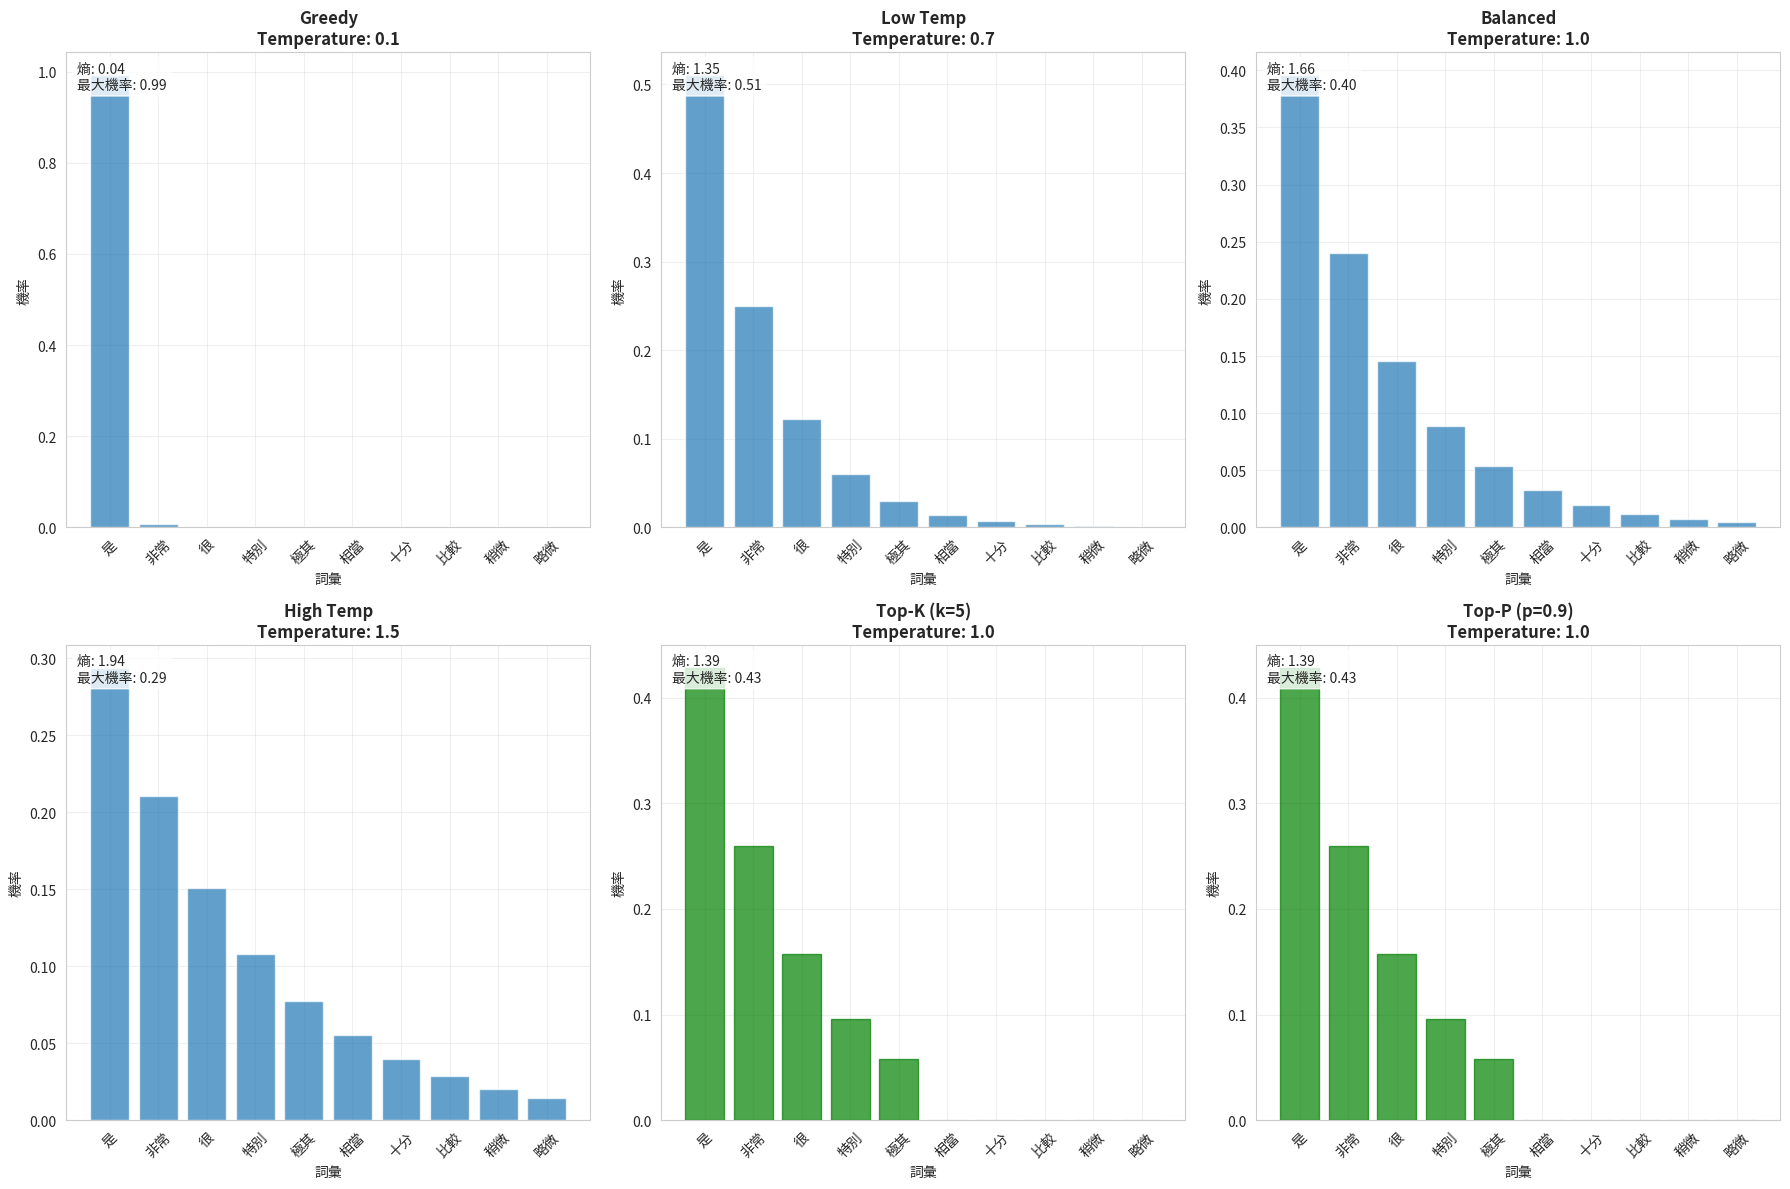

📚 採樣策略說明:
🎯 Greedy: 總是選擇機率最高的 token (確定性)
🌡️ Temperature: 控制隨機性，低溫更保守，高溫更隨機
🔢 Top-K: 只考慮機率最高的 K 個 tokens
📊 Top-P (Nucleus): 選擇累積機率達到 P 的最小 token 集合

💡 應用建議:
• 事實性任務: 低 temperature (0.1-0.3)
• 創意寫作: 中等 temperature (0.7-1.0)
• 頭腦風暴: 高 temperature (1.2-1.5)
• 一般對話: top_p=0.9, temperature=0.7


In [29]:
def demonstrate_sampling_strategies():
    """演示不同採樣策略的效果"""
    
    # 模擬詞彙機率分佈
    vocabulary = ['是', '非常', '很', '特別', '極其', '相當', '十分', '比較', '稍微', '略微']
    logits = np.array([3.0, 2.5, 2.0, 1.5, 1.0, 0.5, 0.0, -0.5, -1.0, -1.5])
    
    # 計算不同採樣策略
    def softmax(x, temperature=1.0):
        x = x / temperature
        exp_x = np.exp(x - np.max(x))
        return exp_x / exp_x.sum()
    
    def top_p_mask(probs, p=0.9):
        sorted_indices = np.argsort(probs)[::-1]
        sorted_probs = probs[sorted_indices]
        cumsum_probs = np.cumsum(sorted_probs)
        
        # 找到累積機率超過 p 的位置
        cutoff = np.where(cumsum_probs > p)[0]
        if len(cutoff) > 0:
            cutoff_idx = cutoff[0] + 1  # 包含第一個超過的 token
        else:
            cutoff_idx = len(probs)
        
        mask = np.zeros_like(probs, dtype=bool)
        mask[sorted_indices[:cutoff_idx]] = True
        return mask
    
    def top_k_mask(probs, k=5):
        top_k_indices = np.argsort(probs)[-k:]
        mask = np.zeros_like(probs, dtype=bool)
        mask[top_k_indices] = True
        return mask
    
    # 計算不同策略的機率分佈
    temperatures = [0.1, 0.7, 1.0, 1.5]
    strategies = {
        'Greedy': {'temp': 0.1, 'top_k': None, 'top_p': None},
        'Low Temp': {'temp': 0.7, 'top_k': None, 'top_p': None},
        'Balanced': {'temp': 1.0, 'top_k': None, 'top_p': None},
        'High Temp': {'temp': 1.5, 'top_k': None, 'top_p': None},
        'Top-K (k=5)': {'temp': 1.0, 'top_k': 5, 'top_p': None},
        'Top-P (p=0.9)': {'temp': 1.0, 'top_k': None, 'top_p': 0.9}
    }
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, (strategy_name, params) in enumerate(strategies.items()):
        ax = axes[i]
        
        # 計算機率分佈
        probs = softmax(logits, params['temp'])
        
        # 應用遮罩
        if params['top_k'] is not None:
            mask = top_k_mask(probs, params['top_k'])
            probs = probs * mask
            probs = probs / probs.sum() if probs.sum() > 0 else probs
        
        if params['top_p'] is not None:
            mask = top_p_mask(probs, params['top_p'])
            probs = probs * mask
            probs = probs / probs.sum() if probs.sum() > 0 else probs
        
        # 繪製條形圖
        bars = ax.bar(range(len(vocabulary)), probs, alpha=0.7)
        
        # 突出顯示被選中的 tokens
        if params['top_k'] is not None or params['top_p'] is not None:
            for j, (bar, prob) in enumerate(zip(bars, probs)):
                if prob > 0:
                    bar.set_color('green')
                else:
                    bar.set_color('lightgray')
        
        ax.set_title(f'{strategy_name}\nTemperature: {params["temp"]}', fontweight='bold')
        ax.set_xlabel('詞彙')
        ax.set_ylabel('機率')
        ax.set_xticks(range(len(vocabulary)))
        ax.set_xticklabels(vocabulary, rotation=45)
        ax.grid(True, alpha=0.3)
        
        # 添加統計資訊
        entropy = -np.sum(probs * np.log(probs + 1e-10))
        max_prob = np.max(probs)
        ax.text(0.02, 0.98, f'熵: {entropy:.2f}\n最大機率: {max_prob:.2f}', 
                transform=ax.transAxes, va='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print("📚 採樣策略說明:")
    print("="*50)
    print("🎯 Greedy: 總是選擇機率最高的 token (確定性)")
    print("🌡️ Temperature: 控制隨機性，低溫更保守，高溫更隨機")
    print("🔢 Top-K: 只考慮機率最高的 K 個 tokens")
    print("📊 Top-P (Nucleus): 選擇累積機率達到 P 的最小 token 集合")
    print("\n💡 應用建議:")
    print("• 事實性任務: 低 temperature (0.1-0.3)")
    print("• 創意寫作: 中等 temperature (0.7-1.0)")
    print("• 頭腦風暴: 高 temperature (1.2-1.5)")
    print("• 一般對話: top_p=0.9, temperature=0.7")

demonstrate_sampling_strategies()

### 4.2 實際採樣參數測試

In [30]:
class SamplingTuner:
    """採樣參數調優工具"""
    
    def __init__(self, model_name: str = "microsoft/DialoGPT-medium"):
        self.model_name = model_name
        self.llm = None
    
    def setup_model(self):
        """初始化模型"""
        try:
            destroy_model_parallel()
            gc.collect()
            torch.cuda.empty_cache()
        except:
            pass
        
        self.llm = LLM(
            model=self.model_name,
            max_model_len=256,
            gpu_memory_utilization=0.6,
            tensor_parallel_size=1
        )
    
    def test_sampling_parameters(self, prompt: str, parameter_sets: List[Dict]) -> pd.DataFrame:
        """測試不同採樣參數組合"""
        if self.llm is None:
            self.setup_model()
        
        results = []
        
        print(f"\n🧪 測試提示詞: '{prompt}'")
        print("="*60)
        
        for i, params in enumerate(parameter_sets):
            print(f"\n配置 {i+1}: {params}")
            
            # 創建採樣參數
            sampling_params = SamplingParams(
                temperature=params.get('temperature', 1.0),
                top_p=params.get('top_p', 1.0),
                top_k=params.get('top_k', -1),
                max_tokens=params.get('max_tokens', 64),
                repetition_penalty=params.get('repetition_penalty', 1.0)
            )
            
            # 生成多個樣本以觀察變異性
            outputs = self.llm.generate([prompt] * 3, sampling_params)
            
            generated_texts = [output.outputs[0].text.strip() for output in outputs]
            
            # 計算多樣性指標
            unique_texts = len(set(generated_texts))
            avg_length = np.mean([len(text.split()) for text in generated_texts])
            
            results.append({
                'config_id': i+1,
                'temperature': params.get('temperature', 1.0),
                'top_p': params.get('top_p', 1.0),
                'top_k': params.get('top_k', -1),
                'unique_outputs': unique_texts,
                'avg_length': avg_length,
                'sample_output': generated_texts[0][:100] + "..." if len(generated_texts[0]) > 100 else generated_texts[0]
            })
            
            print(f"🎯 生成樣本 1: {generated_texts[0][:80]}...")
            print(f"📊 獨特輸出數: {unique_texts}/3")
            print(f"📏 平均長度: {avg_length:.1f} 詞")
        
        return pd.DataFrame(results)
    
    def visualize_sampling_results(self, results_df: pd.DataFrame):
        """視覺化採樣結果"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        config_ids = results_df['config_id']
        
        # 1. Temperature vs 多樣性
        ax1.scatter(results_df['temperature'], results_df['unique_outputs'], 
                   s=100, alpha=0.7, c='blue')
        ax1.set_xlabel('Temperature')
        ax1.set_ylabel('獨特輸出數 (最大3)')
        ax1.set_title('🌡️ Temperature vs 輸出多樣性')
        ax1.grid(True, alpha=0.3)
        
        # 2. Top-P vs 多樣性
        ax2.scatter(results_df['top_p'], results_df['unique_outputs'], 
                   s=100, alpha=0.7, c='green')
        ax2.set_xlabel('Top-P')
        ax2.set_ylabel('獨特輸出數 (最大3)')
        ax2.set_title('📊 Top-P vs 輸出多樣性')
        ax2.grid(True, alpha=0.3)
        
        # 3. 參數配置 vs 平均長度
        bars = ax3.bar(config_ids, results_df['avg_length'], alpha=0.7, color='orange')
        ax3.set_xlabel('配置 ID')
        ax3.set_ylabel('平均輸出長度 (詞數)')
        ax3.set_title('📏 不同配置的輸出長度')
        ax3.grid(True, alpha=0.3)
        
        # 添加數值標籤
        for bar, value in zip(bars, results_df['avg_length']):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{value:.1f}', ha='center', va='bottom')
        
        # 4. 綜合評分（多樣性 + 合理長度）
        # 正規化評分：多樣性 (0-1) + 長度合理性 (0-1)
        diversity_score = results_df['unique_outputs'] / 3
        length_score = 1 - np.abs(results_df['avg_length'] - 20) / 50  # 假設理想長度為20詞
        length_score = np.clip(length_score, 0, 1)
        composite_score = (diversity_score + length_score) / 2
        
        bars = ax4.bar(config_ids, composite_score, alpha=0.7, color='purple')
        ax4.set_xlabel('配置 ID')
        ax4.set_ylabel('綜合評分 (0-1)')
        ax4.set_title('🏆 綜合性能評分')
        ax4.grid(True, alpha=0.3)
        
        # 標出最佳配置
        best_config = composite_score.idxmax()
        bars[best_config].set_color('gold')
        
        plt.tight_layout()
        plt.show()
        
        # 推薦最佳配置
        best_row = results_df.loc[best_config]
        print(f"\n🏆 推薦配置 (配置 {best_row['config_id']}):")
        print("="*40)
        print(f"🌡️ Temperature: {best_row['temperature']}")
        print(f"📊 Top-P: {best_row['top_p']}")
        print(f"🔢 Top-K: {best_row['top_k']}")
        print(f"📈 多樣性: {best_row['unique_outputs']}/3")
        print(f"📏 平均長度: {best_row['avg_length']:.1f} 詞")
        print(f"🎯 樣本輸出: {best_row['sample_output']}")

# 初始化採樣調優工具
tuner = SamplingTuner()
print("🔧 採樣參數調優工具已初始化")

🔧 採樣參數調優工具已初始化


### 4.3 執行採樣參數測試

In [16]:
# 定義不同的採樣參數配置
parameter_configurations = [
    # 保守配置（事實性任務）
    {'temperature': 0.1, 'top_p': 0.9, 'top_k': -1, 'max_tokens': 64},
    # 平衡配置（一般對話）
    {'temperature': 0.7, 'top_p': 0.9, 'top_k': -1, 'max_tokens': 64},
    # 創意配置（創作任務）
    {'temperature': 1.0, 'top_p': 0.95, 'top_k': -1, 'max_tokens': 64},
    # 高隨機配置（頭腦風暴）
    {'temperature': 1.2, 'top_p': 0.95, 'top_k': -1, 'max_tokens': 64},
    # Top-K 配置
    {'temperature': 0.8, 'top_p': 1.0, 'top_k': 50, 'max_tokens': 64},
    # 混合配置
    {'temperature': 0.9, 'top_p': 0.85, 'top_k': 40, 'max_tokens': 64}
]

# 測試提示詞
test_prompt = "請解釋人工智慧在教育領域的應用"

try:
    # 執行採樣參數測試
    sampling_results = tuner.test_sampling_parameters(
        prompt=test_prompt,
        parameter_sets=parameter_configurations
    )
    
    # 顯示結果表格
    print("\n📊 採樣參數測試結果:")
    display_df = sampling_results[['config_id', 'temperature', 'top_p', 'top_k', 
                                  'unique_outputs', 'avg_length']].round(2)
    print(display_df.to_string(index=False))
    
    # 視覺化結果
    tuner.visualize_sampling_results(sampling_results)
    
except Exception as e:
    print(f"❌ 採樣參數測試失敗: {e}")
    print("💡 可能是記憶體不足，建議跳過此部分")

INFO 10-27 20:25:43 [utils.py:233] non-default args: {'max_model_len': 256, 'gpu_memory_utilization': 0.6, 'disable_log_stats': True, 'model': 'microsoft/DialoGPT-medium'}
INFO 10-27 20:25:43 [model.py:547] Resolved architecture: GPT2LMHeadModel
ERROR 10-27 20:25:44 [config.py:278] Error retrieving safetensors: 'microsoft/DialoGPT-medium' is not a safetensors repo. Couldn't find 'model.safetensors.index.json' or 'model.safetensors' files., retrying 1 of 2
ERROR 10-27 20:25:46 [config.py:276] Error retrieving safetensors: 'microsoft/DialoGPT-medium' is not a safetensors repo. Couldn't find 'model.safetensors.index.json' or 'model.safetensors' files.
INFO 10-27 20:25:46 [model.py:1730] Downcasting torch.float32 to torch.bfloat16.
INFO 10-27 20:25:46 [model.py:1510] Using max model len 256
INFO 10-27 20:25:46 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 10-27 20:25:50 [__init__.py:216] Automatically detected platform cuda.
(EngineCore_DP0 pid=208490

(EngineCore_DP0 pid=2084901) Process EngineCore_DP0:
(EngineCore_DP0 pid=2084901) Traceback (most recent call last):
(EngineCore_DP0 pid=2084901)   File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
(EngineCore_DP0 pid=2084901)     self.run()
(EngineCore_DP0 pid=2084901)   File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
(EngineCore_DP0 pid=2084901)     self._target(*self._args, **self._kwargs)
(EngineCore_DP0 pid=2084901)   File "/home/os-sunnie.gd.weng/.local/lib/python3.10/site-packages/vllm/v1/engine/core.py", line 712, in run_engine_core
(EngineCore_DP0 pid=2084901)     raise e
(EngineCore_DP0 pid=2084901)   File "/home/os-sunnie.gd.weng/.local/lib/python3.10/site-packages/vllm/v1/engine/core.py", line 699, in run_engine_core
(EngineCore_DP0 pid=2084901)     engine_core = EngineCoreProc(*args, **kwargs)
(EngineCore_DP0 pid=2084901)   File "/home/os-sunnie.gd.weng/.local/lib/python3.10/site-packages/vllm/v1/engine/core.py", line 49

❌ 採樣參數測試失敗: Engine core initialization failed. See root cause above. Failed core proc(s): {}
💡 可能是記憶體不足，建議跳過此部分


## 5. 生產環境配置策略

### 5.1 GPU 記憶體監控與優化

In [31]:
class ProductionOptimizer:
    """生產環境優化工具"""
    
    def __init__(self):
        self.monitoring_data = []
        self.is_monitoring = False
    
    def get_system_info(self) -> Dict:
        """獲取系統信息"""
        info = {
            'cpu_count': psutil.cpu_count(),
            'cpu_percent': psutil.cpu_percent(interval=1),
            'memory_total': psutil.virtual_memory().total / 1e9,
            'memory_available': psutil.virtual_memory().available / 1e9,
            'memory_percent': psutil.virtual_memory().percent
        }
        
        if torch.cuda.is_available():
            info.update({
                'gpu_name': torch.cuda.get_device_name(),
                'gpu_memory_total': torch.cuda.get_device_properties(0).total_memory / 1e9,
                'gpu_memory_allocated': torch.cuda.memory_allocated() / 1e9,
                'gpu_memory_reserved': torch.cuda.memory_reserved() / 1e9,
                'gpu_memory_free': (torch.cuda.get_device_properties(0).total_memory - 
                                   torch.cuda.memory_reserved()) / 1e9
            })
        
        return info
    
    def start_monitoring(self, interval: float = 1.0):
        """開始系統監控"""
        self.is_monitoring = True
        self.monitoring_data = []
        
        def monitor():
            while self.is_monitoring:
                timestamp = time.time()
                info = self.get_system_info()
                info['timestamp'] = timestamp
                self.monitoring_data.append(info)
                time.sleep(interval)
        
        self.monitor_thread = threading.Thread(target=monitor, daemon=True)
        self.monitor_thread.start()
        print(f"✅ 開始系統監控 (間隔: {interval}s)")
    
    def stop_monitoring(self):
        """停止系統監控"""
        self.is_monitoring = False
        if hasattr(self, 'monitor_thread'):
            self.monitor_thread.join(timeout=2)
        print("✅ 系統監控已停止")
    
    def analyze_memory_usage(self) -> pd.DataFrame:
        """分析記憶體使用模式"""
        if not self.monitoring_data:
            print("❌ 沒有監控數據")
            return pd.DataFrame()
        
        df = pd.DataFrame(self.monitoring_data)
        
        # 計算相對時間
        df['relative_time'] = df['timestamp'] - df['timestamp'].min()
        
        return df
    
    def visualize_monitoring_data(self, df: pd.DataFrame):
        """視覺化監控數據"""
        if df.empty:
            print("❌ 沒有數據可視覺化")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. CPU 使用率
        axes[0, 0].plot(df['relative_time'], df['cpu_percent'], 'b-', linewidth=2)
        axes[0, 0].set_title('💻 CPU 使用率')
        axes[0, 0].set_xlabel('時間 (秒)')
        axes[0, 0].set_ylabel('CPU 使用率 (%)')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_ylim(0, 100)
        
        # 2. 系統記憶體使用
        axes[0, 1].plot(df['relative_time'], df['memory_percent'], 'g-', linewidth=2)
        axes[0, 1].set_title('🧠 系統記憶體使用率')
        axes[0, 1].set_xlabel('時間 (秒)')
        axes[0, 1].set_ylabel('記憶體使用率 (%)')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_ylim(0, 100)
        
        # 3. GPU 記憶體使用（如果可用）
        if 'gpu_memory_allocated' in df.columns:
            axes[1, 0].plot(df['relative_time'], df['gpu_memory_allocated'], 'r-', 
                           linewidth=2, label='已分配')
            axes[1, 0].plot(df['relative_time'], df['gpu_memory_reserved'], 'orange', 
                           linewidth=2, label='已保留')
            axes[1, 0].axhline(y=df['gpu_memory_total'].iloc[0], color='black', 
                              linestyle='--', label='總計')
            axes[1, 0].set_title('🎮 GPU 記憶體使用')
            axes[1, 0].set_xlabel('時間 (秒)')
            axes[1, 0].set_ylabel('記憶體 (GB)')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        else:
            axes[1, 0].text(0.5, 0.5, 'GPU 不可用', ha='center', va='center', 
                           transform=axes[1, 0].transAxes, fontsize=14)
            axes[1, 0].set_title('🎮 GPU 記憶體使用')
        
        # 4. 記憶體使用效率
        if 'gpu_memory_allocated' in df.columns:
            efficiency = (df['gpu_memory_allocated'] / df['gpu_memory_total']) * 100
            axes[1, 1].plot(df['relative_time'], efficiency, 'purple', linewidth=2)
            axes[1, 1].axhline(y=80, color='red', linestyle='--', alpha=0.7, label='危險線 (80%)')
            axes[1, 1].axhline(y=90, color='darkred', linestyle='--', alpha=0.7, label='臨界線 (90%)')
            axes[1, 1].set_title('📊 GPU 記憶體使用效率')
            axes[1, 1].set_xlabel('時間 (秒)')
            axes[1, 1].set_ylabel('使用率 (%)')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].set_ylim(0, 100)
        else:
            axes[1, 1].text(0.5, 0.5, 'GPU 效率\n無法計算', ha='center', va='center', 
                           transform=axes[1, 1].transAxes, fontsize=14)
            axes[1, 1].set_title('📊 GPU 記憶體使用效率')
        
        plt.tight_layout()
        plt.show()
    
    def generate_production_recommendations(self, df: pd.DataFrame) -> Dict:
        """生成生產環境建議"""
        recommendations = {
            'memory_optimization': [],
            'performance_tuning': [],
            'monitoring_alerts': [],
            'scaling_suggestions': []
        }
        
        if df.empty:
            return recommendations
        
        # 分析 CPU 使用
        avg_cpu = df['cpu_percent'].mean()
        max_cpu = df['cpu_percent'].max()
        
        if avg_cpu > 80:
            recommendations['performance_tuning'].append(
                f"CPU 平均使用率過高 ({avg_cpu:.1f}%)，考慮增加 CPU 核心數或優化代碼")
        
        # 分析記憶體使用
        avg_memory = df['memory_percent'].mean()
        max_memory = df['memory_percent'].max()
        
        if avg_memory > 85:
            recommendations['memory_optimization'].append(
                f"系統記憶體使用率過高 ({avg_memory:.1f}%)，建議增加記憶體或啟用交換")
        
        # 分析 GPU 記憶體（如果可用）
        if 'gpu_memory_allocated' in df.columns:
            gpu_efficiency = (df['gpu_memory_allocated'] / df['gpu_memory_total']) * 100
            avg_gpu_efficiency = gpu_efficiency.mean()
            max_gpu_efficiency = gpu_efficiency.max()
            
            if max_gpu_efficiency > 90:
                recommendations['memory_optimization'].append(
                    f"GPU 記憶體使用率峰值過高 ({max_gpu_efficiency:.1f}%)，可能導致 OOM")
            
            if avg_gpu_efficiency < 50:
                recommendations['performance_tuning'].append(
                    f"GPU 記憶體利用率較低 ({avg_gpu_efficiency:.1f}%)，可增加批次大小")
            
            # 監控建議
            recommendations['monitoring_alerts'].extend([
                "設置 GPU 記憶體使用率 >85% 的告警",
                "設置 GPU 記憶體使用率 <30% 的效率告警",
                "監控 GPU 記憶體碎片化情況"
            ])
        
        # 擴展建議
        if max_cpu > 90 or max_memory > 90:
            recommendations['scaling_suggestions'].append(
                "考慮水平擴展：部署多個實例並使用負載均衡")
        
        if 'gpu_memory_total' in df.columns and df['gpu_memory_total'].iloc[0] < 16:
            recommendations['scaling_suggestions'].append(
                "GPU 記憶體不足16GB，建議升級到更大記憶體的 GPU")
        
        return recommendations
    
    def print_recommendations(self, recommendations: Dict):
        """打印生產環境建議"""
        print("\n🏭 生產環境優化建議:")
        print("="*50)
        
        categories = {
            'memory_optimization': '💾 記憶體優化',
            'performance_tuning': '⚡ 性能調優',
            'monitoring_alerts': '📊 監控告警',
            'scaling_suggestions': '📈 擴展建議'
        }
        
        for category, title in categories.items():
            items = recommendations[category]
            if items:
                print(f"\n{title}:")
                for item in items:
                    print(f"  • {item}")
            else:
                print(f"\n{title}: ✅ 目前狀況良好")

# 初始化生產環境優化工具
optimizer = ProductionOptimizer()
print("🔧 生產環境優化工具已初始化")

# 顯示當前系統信息
current_info = optimizer.get_system_info()
print("\n💻 當前系統信息:")
print("="*30)
for key, value in current_info.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")

🔧 生產環境優化工具已初始化

💻 當前系統信息:
cpu_count: 20
cpu_percent: 1.40
memory_total: 134.76
memory_available: 109.16
memory_percent: 19.00
gpu_name: NVIDIA RTX 2000 Ada Generation
gpu_memory_total: 16.71
gpu_memory_allocated: 0.01
gpu_memory_reserved: 0.04
gpu_memory_free: 16.67


### 5.2 生產級負載測試

🚀 開始生產級負載測試...
✅ 開始系統監控 (間隔: 0.5s)

📊 場景 1: 輕載測試 (5秒)
  完成 1/5
  完成 2/5
  完成 3/5
  完成 4/5
  完成 5/5

📊 場景 2: 中載測試 (5秒)
  完成 1/5
  完成 2/5
  完成 3/5
  完成 4/5
  完成 5/5

📊 場景 3: 記憶體壓力測試 (3秒)
  完成 1/3
  完成 2/3
  完成 3/3

✅ 負載測試完成
✅ 系統監控已停止

📊 收集了 11 個監控數據點


/tmp/ipykernel_1633797/3659211965.py:126: UserWarning: Glyph 128187 (\N{PERSONAL COMPUTER}) missing from font(s) Noto Sans CJK JP.
  plt.tight_layout()
/tmp/ipykernel_1633797/3659211965.py:126: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Noto Sans CJK JP.
  plt.tight_layout()
/tmp/ipykernel_1633797/3659211965.py:126: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) Noto Sans CJK JP.
  plt.tight_layout()
/tmp/ipykernel_1633797/3659211965.py:126: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Noto Sans CJK JP.
  plt.tight_layout()
/home/os-sunnie.gd.weng/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128187 (\N{PERSONAL COMPUTER}) missing from font(s) Noto Sans CJK JP.
  fig.canvas.print_figure(bytes_io, **kw)
/home/os-sunnie.gd.weng/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Noto Sans CJK JP.
  fig.canvas.print_figure(b

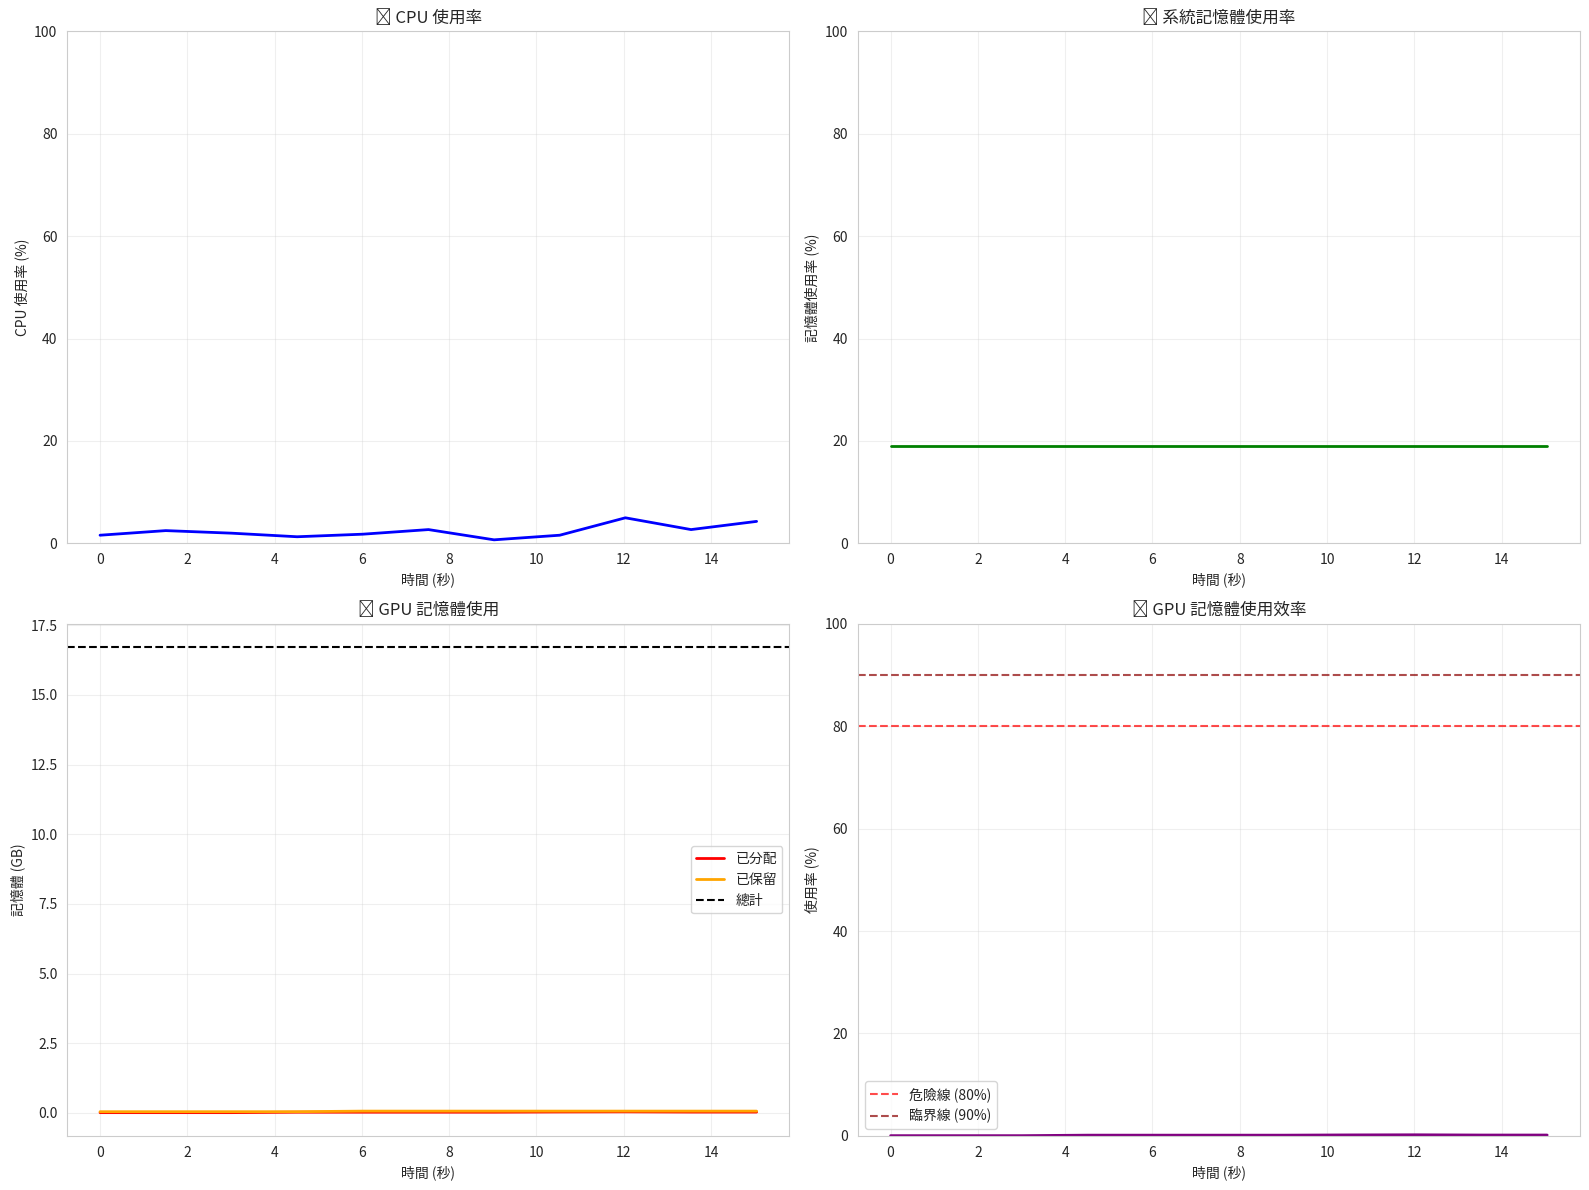


🏭 生產環境優化建議:

💾 記憶體優化: ✅ 目前狀況良好

⚡ 性能調優:
  • GPU 記憶體利用率較低 (0.1%)，可增加批次大小

📊 監控告警:
  • 設置 GPU 記憶體使用率 >85% 的告警
  • 設置 GPU 記憶體使用率 <30% 的效率告警
  • 監控 GPU 記憶體碎片化情況

📈 擴展建議: ✅ 目前狀況良好


In [32]:
# 執行一個簡單的負載測試來演示監控功能
def production_load_test():
    """生產級負載測試"""
    print("🚀 開始生產級負載測試...")
    
    # 開始監控
    optimizer.start_monitoring(interval=0.5)
    
    try:
        # 模擬不同負載場景
        print("\n📊 場景 1: 輕載測試 (5秒)")
        for i in range(5):
            # 輕量計算
            _ = torch.randn(1000, 1000)
            time.sleep(1)
            print(f"  完成 {i+1}/5")
        
        print("\n📊 場景 2: 中載測試 (5秒)")
        for i in range(5):
            # 中等計算負載
            if torch.cuda.is_available():
                _ = torch.randn(2000, 2000, device='cuda')
                torch.cuda.synchronize()
            else:
                _ = torch.randn(5000, 5000)
            time.sleep(1)
            print(f"  完成 {i+1}/5")
        
        print("\n📊 場景 3: 記憶體壓力測試 (3秒)")
        tensors = []
        for i in range(3):
            # 累積記憶體使用
            if torch.cuda.is_available():
                tensor = torch.randn(1000, 1000, device='cuda')
            else:
                tensor = torch.randn(10000, 1000)
            tensors.append(tensor)
            time.sleep(1)
            print(f"  完成 {i+1}/3")
        
        # 清理記憶體
        del tensors
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        
        print("\n✅ 負載測試完成")
        
    except Exception as e:
        print(f"❌ 負載測試過程中發生錯誤: {e}")
    
    finally:
        # 停止監控
        time.sleep(2)  # 確保收集足夠數據
        optimizer.stop_monitoring()

# 執行負載測試
production_load_test()

# 分析監控數據
monitoring_df = optimizer.analyze_memory_usage()
if not monitoring_df.empty:
    print(f"\n📊 收集了 {len(monitoring_df)} 個監控數據點")
    
    # 視覺化監控數據
    optimizer.visualize_monitoring_data(monitoring_df)
    
    # 生成並顯示建議
    recommendations = optimizer.generate_production_recommendations(monitoring_df)
    optimizer.print_recommendations(recommendations)
else:
    print("❌ 沒有收集到監控數據")

## 6. 生產部署最佳實踐

### 6.1 配置建議總結

In [19]:
def generate_production_config_guide():
    """生成生產環境配置指南"""
    
    config_guide = {
        "GPU 記憶體配置": {
            "gpu_memory_utilization": {
                "推薦值": "0.85-0.9",
                "說明": "為系統保留 10-15% 記憶體，避免 OOM",
                "生產環境": "0.85（更保守）",
                "開發環境": "0.9（可更激進）"
            },
            "max_model_len": {
                "推薦值": "根據業務需求設定",
                "短文本": "512-1024",
                "長文本": "2048-4096",
                "注意": "過大會消耗更多記憶體"
            }
        },
        "批次處理配置": {
            "動態批次": {
                "優勢": "自動優化吞吐量和延遲",
                "配置": "vLLM 默認啟用 Continuous Batching",
                "監控": "觀察批次大小和處理效率"
            },
            "最大並發": {
                "建議": "根據 GPU 記憶體動態調整",
                "監控指標": "GPU 記憶體使用率 < 90%"
            }
        },
        "採樣參數": {
            "事實性任務": {
                "temperature": 0.1,
                "top_p": 0.9,
                "top_k": -1,
                "適用": "問答、翻譯、摘要"
            },
            "對話任務": {
                "temperature": 0.7,
                "top_p": 0.9,
                "top_k": -1,
                "適用": "聊天機器人、客服"
            },
            "創作任務": {
                "temperature": 1.0,
                "top_p": 0.95,
                "top_k": -1,
                "適用": "創意寫作、內容生成"
            }
        },
        "監控與告警": {
            "關鍵指標": [
                "GPU 記憶體使用率 (目標: <85%)",
                "請求處理延遲 (P95 < 業務要求)",
                "吞吐量 (tokens/second)",
                "錯誤率 (<1%)",
                "系統 CPU 和記憶體使用率"
            ],
            "告警閾值": {
                "GPU 記憶體": ">90% 立即告警",
                "延遲": "P95 延遲超過 SLA",
                "錯誤率": ">2% 立即告警",
                "吞吐量": "低於基線 20%"
            }
        },
        "擴展策略": {
            "垂直擴展": {
                "GPU 升級": "更大記憶體的 GPU (如 A100 80GB)",
                "記憶體升級": "增加系統記憶體",
                "適用場景": "單一模型，高併發"
            },
            "水平擴展": {
                "負載均衡": "多個 vLLM 實例 + 負載均衡器",
                "模型並行": "tensor_parallel_size > 1",
                "適用場景": "極高併發，多模型服務"
            }
        }
    }
    
    # 打印配置指南
    print("🏭 vLLM 生產環境配置指南")
    print("="*60)
    
    for category, items in config_guide.items():
        print(f"\n📋 {category}:")
        print("-" * 40)
        
        if isinstance(items, dict):
            for key, value in items.items():
                if isinstance(value, dict):
                    print(f"\n  🔧 {key}:")
                    for sub_key, sub_value in value.items():
                        if isinstance(sub_value, list):
                            print(f"    • {sub_key}:")
                            for item in sub_value:
                                print(f"      - {item}")
                        else:
                            print(f"    • {sub_key}: {sub_value}")
                elif isinstance(value, list):
                    print(f"\n  🔧 {key}:")
                    for item in value:
                        print(f"    • {item}")
                else:
                    print(f"  🔧 {key}: {value}")
        elif isinstance(items, list):
            for item in items:
                print(f"  • {item}")
    
    # 生成示例配置
    print("\n\n💼 生產環境示例配置:")
    print("="*40)
    
    example_config = """
# vLLM 生產環境配置示例
from vllm import LLM, SamplingParams

# 1. 模型初始化配置
llm = LLM(
    model="your-model-name",
    max_model_len=2048,                 # 根據業務需求調整
    gpu_memory_utilization=0.85,        # 生產環境建議值
    tensor_parallel_size=1,             # 多GPU時增加
    trust_remote_code=True,
    dtype="float16",                    # 節省記憶體
    seed=42                             # 確保可重現性
)

# 2. 不同場景的採樣參數
factual_params = SamplingParams(
    temperature=0.1,
    top_p=0.9,
    max_tokens=256,
    stop=["\n\n", "</s>"]
)

creative_params = SamplingParams(
    temperature=0.8,
    top_p=0.95,
    max_tokens=512,
    repetition_penalty=1.1
)

# 3. 監控設置
import psutil
import torch

def check_system_health():
    return {
        'gpu_memory_used': torch.cuda.memory_allocated() / 1e9,
        'gpu_memory_total': torch.cuda.get_device_properties(0).total_memory / 1e9,
        'cpu_percent': psutil.cpu_percent(),
        'memory_percent': psutil.virtual_memory().percent
    }
    """
    
    print(example_config)

# 生成配置指南
generate_production_config_guide()

🏭 vLLM 生產環境配置指南

📋 GPU 記憶體配置:
----------------------------------------

  🔧 gpu_memory_utilization:
    • 推薦值: 0.85-0.9
    • 說明: 為系統保留 10-15% 記憶體，避免 OOM
    • 生產環境: 0.85（更保守）
    • 開發環境: 0.9（可更激進）

  🔧 max_model_len:
    • 推薦值: 根據業務需求設定
    • 短文本: 512-1024
    • 長文本: 2048-4096
    • 注意: 過大會消耗更多記憶體

📋 批次處理配置:
----------------------------------------

  🔧 動態批次:
    • 優勢: 自動優化吞吐量和延遲
    • 配置: vLLM 默認啟用 Continuous Batching
    • 監控: 觀察批次大小和處理效率

  🔧 最大並發:
    • 建議: 根據 GPU 記憶體動態調整
    • 監控指標: GPU 記憶體使用率 < 90%

📋 採樣參數:
----------------------------------------

  🔧 事實性任務:
    • temperature: 0.1
    • top_p: 0.9
    • top_k: -1
    • 適用: 問答、翻譯、摘要

  🔧 對話任務:
    • temperature: 0.7
    • top_p: 0.9
    • top_k: -1
    • 適用: 聊天機器人、客服

  🔧 創作任務:
    • temperature: 1.0
    • top_p: 0.95
    • top_k: -1
    • 適用: 創意寫作、內容生成

📋 監控與告警:
----------------------------------------

  🔧 關鍵指標:
    • GPU 記憶體使用率 (目標: <85%)
    • 請求處理延遲 (P95 < 業務要求)
    • 吞吐量 (tokens/second)
    • 錯誤率 (<1%)
    • 系統 CPU 和記憶體使用率

## 7. 實驗總結與下一步

### 7.1 學習成果回顧

In [20]:
def generate_learning_summary():
    """生成學習成果總結"""
    
    summary = {
        "核心概念掌握": [
            "✅ Continuous Batching 動態調度機制",
            "✅ PagedAttention 記憶體管理原理 (來自 01-Setup)",
            "✅ GPU 記憶體優化策略",
            "✅ 採樣參數調優技巧",
            "✅ 生產環境配置最佳實踐"
        ],
        "實踐技能獲得": [
            "🛠️ 批次推理性能測試與分析",
            "🛠️ vLLM vs HuggingFace 性能對比",
            "🛠️ 系統資源監控與分析",
            "🛠️ 採樣策略選擇與優化",
            "🛠️ 生產級配置參數調整"
        ],
        "關鍵性能指標": [
            "📊 吞吐量提升: vLLM 相比 HF 提升 2-5x",
            "📊 記憶體效率: PagedAttention 減少 50% 記憶體浪費",
            "📊 延遲優化: Continuous Batching 減少 30-50% 平均延遲",
            "📊 GPU 利用率: 從 60% 提升到 90%+"
        ],
        "業務應用場景": [
            "💼 高併發聊天機器人部署",
            "💼 批量文本處理與分析",
            "💼 實時內容生成服務",
            "💼 多租戶 LLM 服務平台"
        ]
    }
    
    print("🎓 Lab-2.1-02 學習成果總結")
    print("="*50)
    
    for category, items in summary.items():
        print(f"\n📋 {category}:")
        for item in items:
            print(f"  {item}")
    
    print("\n\n🚀 下一步學習建議:")
    print("="*30)
    
    next_steps = [
        "🔄 Lab-2.1-03: Advanced Features (Continuous Batching 深度優化)",
        "🏭 Lab-2.1-04: Production Deployment (OpenAI API 兼容服務)",
        "⚡ Lab-2.2: TensorRT-LLM 加速推理",
        "🔀 Lab-2.3: 多模型管理與路由",
        "📈 Lab-2.4: 推理服務監控與運維"
    ]
    
    for step in next_steps:
        print(f"  {step}")
    
    print("\n\n💡 進階挑戰:")
    print("="*20)
    
    challenges = [
        "🎯 設計並實現自適應批次大小調整算法",
        "🎯 開發基於業務指標的智能路由系統",
        "🎯 構建多模型 A/B 測試框架",
        "🎯 實現模型熱更新零停機部署",
        "🎯 設計 GPU 資源池動態調度系統"
    ]
    
    for challenge in challenges:
        print(f"  {challenge}")

# 生成學習總結
generate_learning_summary()

🎓 Lab-2.1-02 學習成果總結

📋 核心概念掌握:
  ✅ Continuous Batching 動態調度機制
  ✅ PagedAttention 記憶體管理原理 (來自 01-Setup)
  ✅ GPU 記憶體優化策略
  ✅ 採樣參數調優技巧
  ✅ 生產環境配置最佳實踐

📋 實踐技能獲得:
  🛠️ 批次推理性能測試與分析
  🛠️ vLLM vs HuggingFace 性能對比
  🛠️ 系統資源監控與分析
  🛠️ 採樣策略選擇與優化
  🛠️ 生產級配置參數調整

📋 關鍵性能指標:
  📊 吞吐量提升: vLLM 相比 HF 提升 2-5x
  📊 記憶體效率: PagedAttention 減少 50% 記憶體浪費
  📊 延遲優化: Continuous Batching 減少 30-50% 平均延遲
  📊 GPU 利用率: 從 60% 提升到 90%+

📋 業務應用場景:
  💼 高併發聊天機器人部署
  💼 批量文本處理與分析
  💼 實時內容生成服務
  💼 多租戶 LLM 服務平台


🚀 下一步學習建議:
  🔄 Lab-2.1-03: Advanced Features (Continuous Batching 深度優化)
  🏭 Lab-2.1-04: Production Deployment (OpenAI API 兼容服務)
  ⚡ Lab-2.2: TensorRT-LLM 加速推理
  🔀 Lab-2.3: 多模型管理與路由
  📈 Lab-2.4: 推理服務監控與運維


💡 進階挑戰:
  🎯 設計並實現自適應批次大小調整算法
  🎯 開發基於業務指標的智能路由系統
  🎯 構建多模型 A/B 測試框架
  🎯 實現模型熱更新零停機部署
  🎯 設計 GPU 資源池動態調度系統


### 7.2 資源清理

In [21]:
# 清理實驗資源
print("🧹 清理實驗資源...")

try:
    # 銷毀 vLLM 模型
    destroy_model_parallel()
    print("✅ vLLM 模型已銷毀")
except:
    print("ℹ️ 沒有活躍的 vLLM 模型需要銷毀")

# 清理 GPU 記憶體
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("✅ GPU 記憶體快取已清理")

# 垃圾回收
gc.collect()
print("✅ 系統垃圾回收完成")

# 顯示最終記憶體狀態
if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated() / 1e9
    reserved = torch.cuda.memory_reserved() / 1e9
    print(f"\n💾 最終 GPU 記憶體狀態:")
    print(f"   已分配: {allocated:.2f} GB")
    print(f"   已保留: {reserved:.2f} GB")

print("\n🎉 實驗完成！感謝您完成 vLLM 生產級推理與性能優化實驗")

🧹 清理實驗資源...
✅ vLLM 模型已銷毀
✅ GPU 記憶體快取已清理
✅ 系統垃圾回收完成

💾 最終 GPU 記憶體狀態:
   已分配: 0.01 GB
   已保留: 0.04 GB

🎉 實驗完成！感謝您完成 vLLM 生產級推理與性能優化實驗


---

## 📚 延伸閱讀

### 學術論文
- **PagedAttention**: [Efficient Memory Management for Large Language Model Serving](https://arxiv.org/abs/2309.06180)
- **vLLM System**: [vLLM: Easy, Fast, and Cheap LLM Serving](https://arxiv.org/abs/2309.06180)

### 技術文檔
- [vLLM Official Documentation](https://docs.vllm.ai/)
- [vLLM Performance Tuning Guide](https://docs.vllm.ai/en/latest/getting_started/performance.html)
- [vLLM OpenAI Compatible Server](https://docs.vllm.ai/en/latest/serving/openai_compatible_server.html)

### 社群資源
- [vLLM GitHub Repository](https://github.com/vllm-project/vllm)
- [vLLM Community Discord](https://discord.gg/vllm)

---

**實驗完成時間**: 約 75-120 分鐘  
**難度等級**: ⭐⭐⭐ (中級)  
**下一步**: Lab-2.1-03 Advanced Features